In [1]:
import sys
!{sys.executable} -m pip install opencv-contrib-python --upgrade

In [2]:
import cv2
import numpy as np
import math 

# Create the haar cascade
faceCascade = cv2.CascadeClassifier("./data/haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread("./data/side.jpg")
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)


In [3]:
# Draw a rectangle around the face and get the corresponding area
for (x, y, w, h) in faces:
    face = image[y:y+h,x:x+w]
    face_rgb = rgb[y:y+h,x:x+w]
    face_gray= gray[y:y+h,x:x+w]
    face_rect_lab = lab[y:y+h,x:x+w]
    face_rect_hsv = hsv[y:y+h,x:x+w]

cv2.imshow("Face Found",image)
cv2.imshow("Face Mask RGB",face_rgb)
cv2.imshow("Face Mask LAB",face_rect_lab)
cv2.imshow("Face Mask HSV",face_rect_hsv)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
from scipy.signal import convolve2d

# Get skin mask
def elipse_mask(a,b):
    return ((a-143.0)/6.5)**2 + ((b-148.0)/12)**2

def hsv_mask(h,s):
    return (s>=0.25 and s<=0.75) and h<=0.095


def skin_detection():
    l,a,b = cv2.split(face_rect_lab)
    h,s,v = cv2.split(face_rect_hsv)
    skin_mask = np.zeros((face.shape[0],face.shape[1]))
    ellipse_test = np.vectorize(lambda a,b: 1 if elipse_mask(a,b) < 1 else 0)
    skin_mask = ellipse_test(a,b)
    hsv_test = np.vectorize(lambda h,s,m: 1 if m > 0.95 and hsv_mask(h,s) else 0)
    skin_mask = hsv_test(h/179.0,s/255.0,skin_mask)
    large_ellipse_test = np.vectorize(lambda m,a,b: 1 if elipse_mask(a,b) < 1.25 and m == 1 else 0)
    skin_mask = large_ellipse_test(skin_mask,a,b)
    return skin_mask.astype(np.uint8)

def rgb_skin_detection():
    b,g,r = cv2.split(face)
    skin_mask = np.zeros((face.shape[0],face.shape[1]))
    rgb_test = np.vectorize(lambda r,g,b: 1 if r > 95 and g > 40 and b > 20 and max(r,g,b) - min(r,g,b) > 15 and abs(r-g) > 15 and r > g and r > b else 0)
    skin_mask = rgb_test(r,g,b)
    return skin_mask.astype(np.uint8)  
    
skin_mask = skin_detection()
rgb_skin_mask = rgb_skin_detection()
final_skin_mask = cv2.bitwise_or(skin_mask,rgb_skin_mask)

skin = cv2.bitwise_and(face, face, mask = skin_mask)
rgb_skin = cv2.bitwise_and(face, face, mask = rgb_skin_mask)
final_skin = cv2.bitwise_and(face, face, mask = final_skin_mask)
cv2.imshow("Skin Found",np.hstack([face,skin]))
cv2.imshow("RGB Skin Found",np.hstack([face,rgb_skin]))
cv2.imshow("Final Skin Found",np.hstack([face,final_skin]))
cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\gbata\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# Adapted from https://github.com/drakeguan/cp11fall_project1/blob/master/wlsFilter/wlsFilter.m
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
def wls_filter(img_l,alpha=1.0,l=0.5, eps=sys.float_info.epsilon):
    
    img_l = img_l.astype(float)/255.0
    r,c = img_l.shape
    k = r*c

    # Compute affinities between adjacent pixels based on gradients of L
    dy = np.diff(img_l, 1, 0);
    dy = -l / (np.absolute(dy)**alpha + eps)
    dy = (np.vstack((dy, np.zeros(c, )))).flatten('F')

    dx = np.diff(img_l, 1, 1); 
    dx = -l / (np.absolute(dx)**alpha + eps)
    dx = (np.hstack((dx, np.zeros(r, )[:, np.newaxis]))).flatten('F')


    # Construct a five-point spatially inhomogeneous Laplacian matrix
    B = np.vstack((dx,dy))
    d = [-r,-1]
    A = spdiags(B,d,k,k)

    e = dx
    w = np.roll(dx,r)
    s = dy
    n = np.roll(dy,1)

    D = 1 - (e+w+s+n);
    A = A + A.T + spdiags(D, 0, k, k);

    #Solve
    OUT = spsolve(A, img_l.flatten('F')).reshape(img_l.shape[::-1])
    
    base = np.rollaxis(OUT,1)
    detail = img_l - base
    return base,detail

In [6]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

#Change params depending on smoothing
def smoothing(skin):
    intensity = (skin*255).clip(0, 255).astype(np.uint8)
    hist = cv2.calcHist([intensity], [0], None, [256], [1, 256])
    histT_list = hist.T.ravel()
    return np.correlate(histT_list, cv2.getGaussianKernel(
        40, 20).ravel(), 'same')


def find_accurate_peaks(hist):
    return argrelextrema(hist, np.greater_equal, order=1)[0]

def find_s_peak(l,r,left,right,peaks,f_peak):
    s_peak = None
    if len(left) > 0 and len(right) > 0:
        if left[0]<right[-1]:
            s_peak = l[left[0]]
        else:
            s_peak = r[right[-1]]
    elif len(right) > 0:
        s_peak = r[right[-1]]
    else:
        s_peak = l[left[0]]

    if s_peak is None:
        dist = np.argmax(np.absolute(peaks-peaks[f_peak]))
        s_peak = peaks[dist]
    return s_peak


def bimodal_check(hist):
    peaks = argrelextrema(hist, np.greater, order=3)[0]
    if len(peaks) < 2: return False, None, None, None
    f_peak = np.argmax(hist[peaks])
    left, right = peaks[:f_peak], peaks[f_peak+1:]
    true_left, true_right = find_accurate_peaks(hist[left]), find_accurate_peaks(hist[right])
    s_peak = find_s_peak(left,right,true_left,true_right,peaks,f_peak)
    d, b = peaks[f_peak] if peaks[f_peak] < s_peak else s_peak, peaks[f_peak] if peaks[f_peak] > s_peak else s_peak
    print(d,b)
    m = np.argmin(hist[d:b])+d
    return True, d, m, b


In [7]:
"""
Algorithm 1. CorrectFace(I,F,Mskin)
Require: I – input image (luminance channel).
Require: F – detected face rectangle.
Require: Mskin – skin mask.
Ensure: Iout – adjusted image (luminance channel).
1: // Perform edge-preserving base/detail decomposition
2: (Base,Detail) = W LSFilter(I)
3: Iout = Base
4: // Sidelight correction
5: S = F Mskin // skin pixels inside F
6: H = Smoothed histogram of intensities in Iout[S]
7: if H is bimodal (sidelit face) then
8: d = intensity of dark mode in H
9: b = intensity of bright mode in H
10: m = intensity at local minimum between d and b
11: f = b−d m−d
12: A = adjustment map scaling by f every pixel ∈ S
with intensity ≤ m
13: Apply edge-aware constraint propagation to A
14: Iout = Iout ·A // pixelwise multiplication
15: end if
16: // Exposure Correction
17: p = 75th percentile of face skin pixels S
18: if p < 120 (underexposed face) then
19: f = 120+p/2p ; ensure 1 ≤ f ≤ 2
20: A = adjustment map scaling by f every pixel ∈ S
21: Apply edge-aware constraint propagation to A
22: Iout = Iout ·A // pixelwise multiplication
23: end if
24: Iout+ = Detail
"""

def sidelit_correction(base,skin,d,m,b,x,y,w,h):
    base = (base*255).clip(0,255).astype(np.uint8)
    skin = skin*255
    f = (b-d)/(m-d)
    A = np.ones(base.shape)
    A[y:y+h,x:x+w][(skin<=m) & (skin>0)] = f
    A =  cv2.edgePreservingFilter(A,30, 10)
    cv2.imshow("Sidelit",np.hstack([base,base*A]))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return base*A

def exposure_correction(base,skin,p,x,y,w,h):
    base = (base*255).clip(0,255).astype(np.uint8)
    skin = skin*255
    f = (120+p)/(2*p)
    f = np.clip(f,1,2)
    A = np.ones(base.shape)
    A[y:y+h,x:x+w][skin>0] = f
    A = cv2.edgePreservingFilter(A,30,10)
    cv2.imshow("Underexposed",np.hstack([base,base*A]))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return base * A

def correct_face(img,face,skin_mask):
    # Perform edge-preserving base/detail decomposition
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    l,a,b = cv2.split(lab)
    base,detail = wls_filter(l)
    cv2.imshow("Base",base)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #S = F Mskin // skin pixels inside F
    face_base = base[y:y+h,x:x+w]
    skin = cv2.bitwise_and(face_base, face_base, mask = skin_mask)
    cv2.imshow("Skin Found",np.hstack([face_base,skin]))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    #H = Smoothed histogram of intensities in Iout[S]
    hist = smoothing(skin)
    plt.plot(hist)
    plt.show()
    # Sidelight correction
    sidelit, d, m, b = bimodal_check(hist)
    if sidelit:
        print("Bimodal")
        base = sidelit_correction(base,skin,d,m,b,x,y,w,h)
    
    # Exposure Correction
    face_base = base[y:y+h,x:x+w]
    skin = cv2.bitwise_and(face_base, face_base, mask = skin_mask)
    cv2.imshow("Skin Found",np.hstack([face_base,skin]))
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    p = np.percentile(img[skin],75)
    if p < 120:
        print("Underexposed")
        base = exposure_correction(base,skin,p,x,y,w,h)

    lab[:,:,0] = (base+detail*255).clip(0,255)
    return cv2.cvtColor(lab, cv2.COLOR_Lab2BGR)



C:\Users\gbata\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


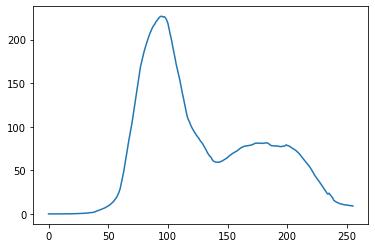

95 183
Bimodal


In [8]:
img_out = correct_face(image,face,final_skin_mask)

In [9]:
cv2.imshow("Original",image)
cv2.imshow("Final Result",img_out)
cv2.waitKey(0)
cv2.destroyAllWindows()